In [1]:
import numpy as np
import pysindy as ps
import networkx as nx
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [2]:
def bio(data, t):
    F = 5
    B = 1
    R = 3
    
    n = len(data)
    result = np.empty(n)
    
    for i in range(0,n):
        sigma = 0
        for j in range (0,n):
            sigma = sigma + R*(adjacency[i,j])*data[i]*data[j]
        result[i] = F - B*data[i] - sigma
    
    return result

In [3]:
library_functions = [
    lambda : 1,
    lambda x : x,
    lambda x,y : x*y
]
library_function_names = [
    lambda : 1,
    lambda x : x,
    lambda x,y : '' + x + '.' + y
]

"""
input:
    an array with len=number_of_nodes
output: 
    and array with len=len(custom_library.get_feature_names())
example:
    input = [0., 0., 1., 1,]
    output = [1, data[0], data[1], data[2], data[3], 
            data[0]*data[1], data[0]*data[2], data[0]*data[3],
            data[1]*data[2], data[1]*data[3], data[2]*data[3]]
"""
def library_parser(data):
    n = len(data)
    result = [None] * int(1 + n + n*(n-1)/2)
    result[0] = 1
    for i in range(0,n):
        result[i+1] = data[i]
    index = 0
    for i in range(0,n):
        for j in range(i+1,n):
            index += 1
            result[n+index] = data[i]*data[j]
    return result

In [17]:
number_of_nodes = 10
#graph = nx.erdos_renyi_graph(number_of_nodes, 0.2)
#graph = nx.connected_watts_strogatz_graph(number_of_nodes, 4, 0.9)
#graph = nx.barabasi_albert_graph(number_of_nodes, int(number_of_nodes/5)) 
graph = nx.scale_free_graph(number_of_nodes)
adjacency = nx.to_numpy_matrix(graph).A


In [18]:
dt = .01

t_train = np.arange(0, 100, dt)
x0_train = np.random.rand(number_of_nodes) * 10
x_train = odeint(bio, x0_train, t_train)

custom_library = ps.CustomLibrary(
    library_functions=library_functions, function_names=library_function_names
)

model = ps.SINDy(feature_library=custom_library)
model.fit(x_train, t=dt)
model.print()

x0' = 636358.085 1 + 2300044.568 x0 + -1564737.926 x1 + -1791505.869 x2 + 1234758.402 x3 + -43168.693 x5 + -1702176.115 x7 + 1537880.977 x9 + -447527.077 x0.x1 + -299239.970 x0.x2 + 373911.772 x0.x3 + -137515.526 x0.x4 + -280224.823 x0.x5 + -121792.198 x0.x6 + -487767.872 x0.x7 + -238234.317 x0.x8 + -257941.417 x0.x9 + 1036007.054 x1.x2 + 3775514.666 x1.x3 + 19607.152 x1.x5 + 2045985.047 x1.x7 + 60989.428 x1.x8 + 40010.980 x1.x9 + -211327.918 x2.x3 + -434101.832 x2.x4 + 1097115.085 x2.x7 + 618077.079 x2.x8 + -346463.870 x2.x9 + 118068.787 x3.x4 + -65052.862 x3.x5 + 150456.822 x3.x6 + -4483534.608 x3.x7 + -86959.231 x3.x8 + -1293293.565 x3.x9 + 160317.996 x4.x5 + 633055.866 x4.x6 + -1630218.645 x4.x7 + -67507.464 x4.x8 + 94176.800 x4.x9 + 223573.505 x5.x6 + 23630.656 x5.x7 + -243815.822 x5.x8 + 91413.226 x5.x9 + -134797.102 x6.x8 + 137433.965 x6.x9 + 68163.409 x7.x8 + 105374.628 x7.x9
x1' = -0.442 x0 + -0.151 x5 + 2.490 x0.x2 + -4.493 x1.x2 + -7.597 x1.x3 + -2.638 x1.x7 + 5.077 x1.x8 + 

In [20]:
def find_steady_state(X):
    prev_state = X[0]
    for i in range(1,len(X)):
        state = X[i]
        diff = np.subtract(state, prev_state)
        prev_state = state
        if -0.0001 < max(np.amax(diff), np.amin(diff), key=abs) < 0.0001:
            return state

real_steady_state = find_steady_state(x_train)        
        
def bio_sindy(data, t):
    cf = library_parser(data)
    result = np.empty(len(data))
    for index in range(0, len(data)):
        sum = 0
        for i in range(0, len(cf)):
            sum += coefficients[index][i] * cf[i]
        result[index] = sum
    return result

coefficients = model.coefficients()
x_test = odeint(bio_sindy, x0_train, t_train)
sindy_steady_state = find_steady_state(x_test)

print('real_steady_state:', real_steady_state)
print('sindy_steady_state:', sindy_steady_state)

real_steady_state: [0.80637075 0.92755788 1.46271113 0.92762146 1.46393885 1.31925402
 1.46405956 0.92755477 1.46317433 0.925715  ]
sindy_steady_state: [0.80637075 0.92755788 1.46271113 0.92762146 1.46393885 1.31925402
 1.46405956 0.92755477 1.46317433 0.925715  ]


In [6]:
def apply_perturbation(alpha, perturbed_node, steady_state, dynamic_func):
    perturbation = np.zeros(number_of_nodes)
    perturbation[perturbed_node] = steady_state[perturbed_node] * alpha
    perturbed = np.add(steady_state, perturbation)

    t_perturbed = np.arange(0, 100, dt)
    x_perturbed = odeint(dynamic_func, perturbed, t_perturbed)
    return x_perturbed

In [21]:
alpha = 0.5
perturbed_node = 1

x_train_perturbed = apply_perturbation(alpha, perturbed_node, real_steady_state, bio)
x_sindy_perturbed = apply_perturbation(alpha, perturbed_node, sindy_steady_state, bio_sindy)

In [22]:
perturbed_train_steady_state = find_steady_state(x_train_perturbed)
perturbed_sindy_steady_state = find_steady_state(x_sindy_perturbed)

print('perturbed_train_steady_state:', perturbed_train_steady_state)
print('perturbed_sindy_steady_state:', perturbed_sindy_steady_state)

perturbed_train_steady_state: [0.80650953 0.92730062 1.46273323 0.92722317 1.46273872 1.3247501
 1.46273925 0.92722315 1.4627353  0.92721481]
perturbed_sindy_steady_state: [-2.72339291e-04  4.62191331e-04  5.46580319e-05  4.04288640e-04
 -1.30382120e-03  2.06616438e-03 -1.43738421e-03  4.65031457e-04
 -4.57873434e-04  2.51264623e-03]


In [23]:
def flow(X):
    prev_state = X[0]
    result = np.empty((0,len(prev_state)))
    for i in range(1,len(X)):
        state = X[i]
        diff = np.subtract(state, prev_state)
        result = np.vstack((result, diff))
        prev_state = state
        if -0.0001 < max(np.amax(diff), np.amin(diff), key=abs) < 0.0001:
            return result
    print('chaos state')
    return result

x_train_flow = flow(x_train_perturbed)
x_sindy_flow = flow(x_sindy_perturbed)

In [12]:
def plot_flow(flow):
    fpr = 2
    plt.rcParams["figure.figsize"] = (16, 9)

    plt.figure(1)
    fig, axs = plt.subplots(int(number_of_nodes/fpr), fpr)
    for i in range(0,number_of_nodes):
        axsi = axs[int(i/fpr), i%fpr]
        axsi.plot(flow[:,i])
        axsi.set_title('\u0394x'+str(i))
    #     axsi.set_ylim(0.1,-0.1)

    plt.show()

<Figure size 1152x648 with 0 Axes>

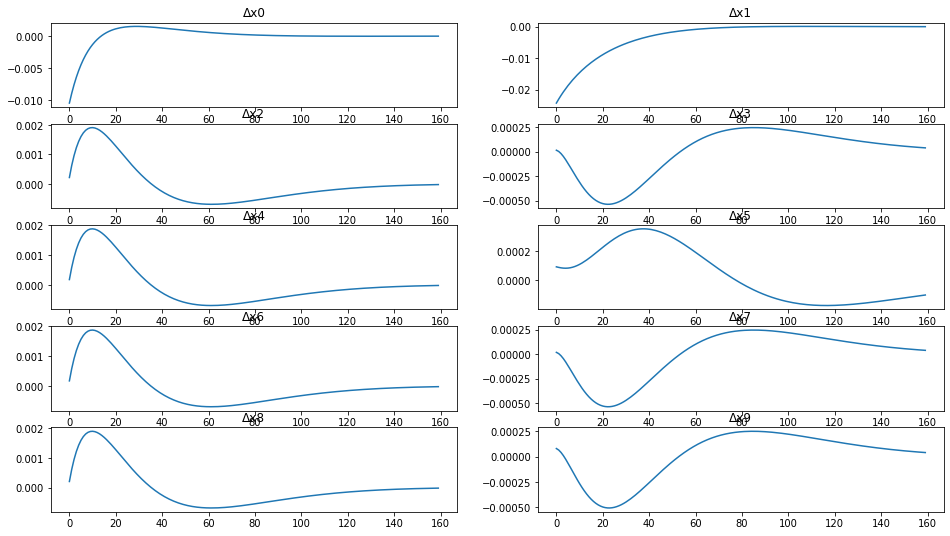

In [24]:
plot_flow(x_train_flow)

<Figure size 1152x648 with 0 Axes>

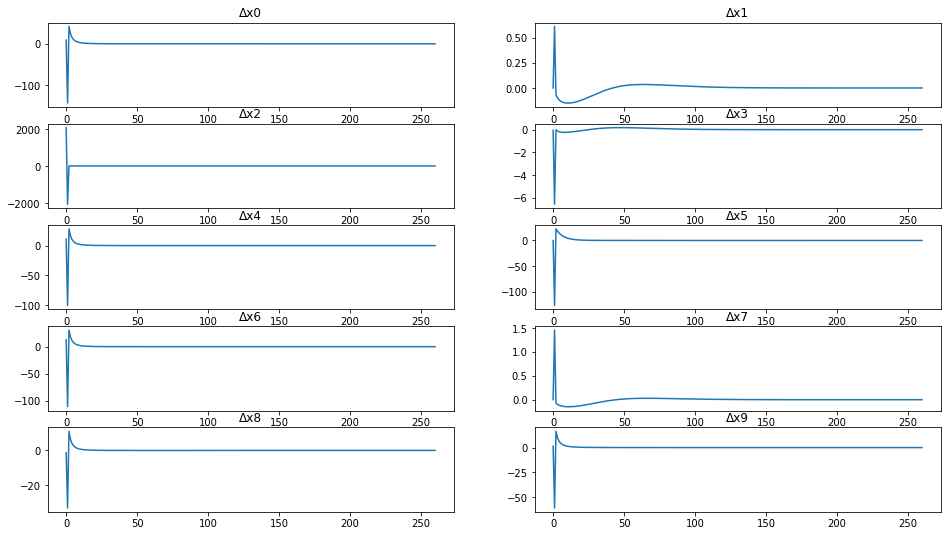

In [25]:
plot_flow(x_sindy_flow)

[(0, 7), (1, 2), (2, 4), (3, 2), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1)]


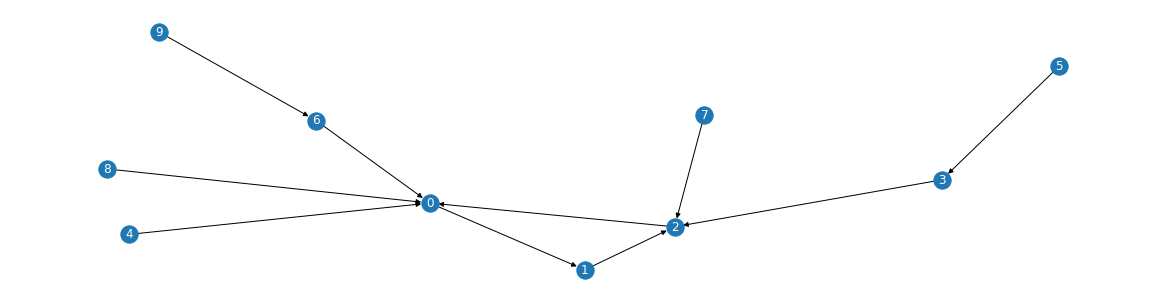

In [93]:
print(graph.degree)
nx.draw(graph, with_labels=True, font_color='white')

In [47]:
def calculate_g(alpha, steady_state, dynamic_func):
    g_matrix = np.empty((number_of_nodes,number_of_nodes))
    t_perturbed = np.arange(0, 10, dt)
    
    for i in range(0, number_of_nodes):
        perturbation_i = np.zeros(number_of_nodes)
        perturbation_i[i] = steady_state[i] * alpha
        perturbed_i = np.add(steady_state, perturbation_i[i])

        x_perturbed_i = odeint(dynamic_func, perturbed_i, t_perturbed)
        final_state_i = x_perturbed_i[-1]
        diff_i = np.subtract(final_state_i, steady_state)

        dxi_xi = diff_i[i]/steady_state[i]
        for j in range(0, number_of_nodes):
            dxj_xj = diff_i[j]/steady_state[j]
            g_matrix[i,j] = abs(dxi_xi/dxj_xj)
    
    return g_matrix

def find_g_dist(g_matrix):
    g_dist = []
    for row in g_matrix:
        for gij in row:
            g_dist.append(gij)
    return g_dist

In [30]:
g_matrix_train = calculate_g(alpha, real_steady_state, bio)
g_matrix_sindy = calculate_g(alpha, sindy_steady_state, bio_sindy)

# print(g_matrix_train)
# print(g_matrix_sindy)

<Figure size 1152x288 with 0 Axes>

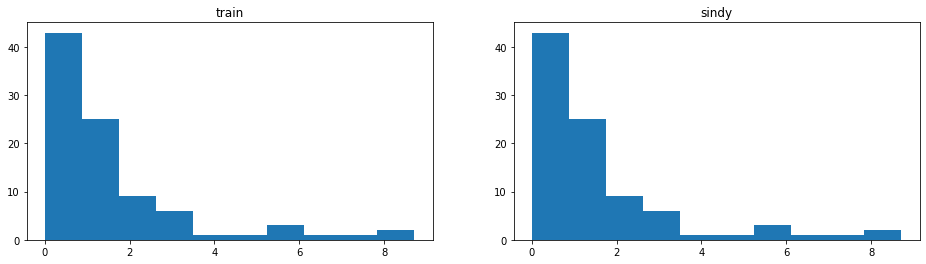

In [48]:
g_train_dist = find_g_dist(g_matrix_train)
g_sindy_dist = find_g_dist(g_matrix_sindy)

plt.rcParams["figure.figsize"] = (16, 4)
plt.figure(2)
fig, axs = plt.subplots(1, 2)
axs[0].hist(g_train_dist)
axs[0].set_title('train')
axs[1].hist(g_sindy_dist)
axs[1].set_title('sindy')
plt.show()

In [37]:
def calculate_f(g_matrix):
    f = np.zeros(number_of_nodes)
    for i in range(0, number_of_nodes):
        f_i = np.zeros(number_of_nodes)
        for n in range(0, number_of_nodes):
            sum_gmn = 0
            for m in range(0, number_of_nodes):
                sum_gmn += g_matrix[m,n]
            sum_gmi = 0
            for m in range(0, number_of_nodes):
                if i==m:
                    continue
                sum_gmi += g_matrix[m,i]/sum_gmn
            f_i[n] = g_matrix[i,n] * sum_gmi

        for n in range(0, number_of_nodes):
            if i==n:
                continue
            f[i] += f_i[n]
        f[i] /= (number_of_nodes-1)
    
    return f

In [38]:
f_train = calculate_f(g_matrix_train)
f_sindy = calculate_f(g_matrix_sindy)

print(f_train)
print(f_sindy)

[0.96379217 0.9409021  0.99584299 0.94960224 0.88943657 0.79710012
 0.87898454 0.94047533 0.95567663 0.68818735]
[0.96379213 0.9409021  0.99584299 0.94960224 0.88943657 0.79710014
 0.87898454 0.94047533 0.95567663 0.68818735]
